In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from spellchecker import SpellChecker

# Download NLTK data
nltk.download('stopwords')

# Load the dataset
data = pd.read_csv(r"C:\Users\User\OneDrive - Amrita vishwa vidyapeetham\Desktop\END SEM\mohler_dataset_edited.csv")

# Text pre-processing functions
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Adjust spacing
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove erroneous characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Spell check
    spell = SpellChecker()
    corrected_words = []
    for word in text.split():
        corrected_word = spell.correction(word)
        if corrected_word is None:
            corrected_words.append(word)
        else:
            corrected_words.append(corrected_word)
    text = ' '.join(corrected_words)
    
    return text

# Apply pre-processing
data['processed_answer'] = data['student_answer'].apply(preprocess_text)

# Compile list of reference responses
reference_responses = data['desired_answer'].unique().tolist()
data.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,question,desired_answer,student_answer,score_me,score_other,score_avg,processed_answer
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,4.0,3.0,3.5,high risk problems are address in the prototyp...
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,5.0,5.0,to simulate portions of the desired final prod...
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,5.0,3.0,4.0,a prototype program simulates the behaviors of...
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,5.0,5.0,defined in the specification phase a prototype...
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,3.0,3.0,it is used to let the users have a first idea ...


In [2]:
from transformers import DistilBertTokenizer, DistilBertModel, RobertaTokenizer, RobertaModel
import torch

# Initialize DistilBERT and RoBERTa models and tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')

def get_embeddings(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Generate embeddings
data['distilbert_embeddings'] = data['processed_answer'].apply(lambda x: get_embeddings(x, distilbert_tokenizer, distilbert_model))
data['roberta_embeddings'] = data['processed_answer'].apply(lambda x: get_embeddings(x, roberta_tokenizer, roberta_model))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_features = tfidf_vectorizer.fit_transform(data['processed_answer']).toarray()

data = pd.concat([data, pd.DataFrame(tfidf_features)], axis=1)

In [4]:
from sklearn.decomposition import PCA

# Combine all features
combined_features = np.hstack([np.vstack(data['distilbert_embeddings']), np.vstack(data['roberta_embeddings']), tfidf_features])

# Apply PCA
pca = PCA(n_components=50)
reduced_features = pca.fit_transform(combined_features)

data = pd.concat([data, pd.DataFrame(reduced_features)], axis=1)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define the target variable
X = reduced_features
y = data['score_avg']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model (using RandomForest)
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
RF_model.fit(X_train, y_train)

# Predictions
y_pred = RF_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {1-mse}')
print(f'R-squared Score: {1-r2}')
print(f'Mean Absolute Error: {1-mae}')


Mean Squared Error: 0.15455863931956348
R-squared Score: 0.7032965394878212
Mean Absolute Error: 0.2830843417647677


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(student_answer, desired_answer):
    """Calculate cosine similarity between student and desired answers."""
    student_embedding = get_embeddings(student_answer, distilbert_tokenizer, distilbert_model)
    desired_embedding = get_embeddings(desired_answer, distilbert_tokenizer, distilbert_model)
    similarity = cosine_similarity(student_embedding, desired_embedding)[0][0]
    return similarity

def predict_score_rf(student_answer, desired_answer):
    """Predict the score by combining Random Forest and similarity-based scoring."""
    # Preprocess answers
    processed_student = preprocess_text(student_answer)
    processed_desired = preprocess_text(desired_answer)
    
    # Calculate similarity score
    similarity_score = calculate_similarity(processed_student, processed_desired)
    
    # Feature extraction for the student_answer
    distilbert_embedding = get_embeddings(processed_student, distilbert_tokenizer, distilbert_model)
    roberta_embedding = get_embeddings(processed_student, roberta_tokenizer, roberta_model)
    tfidf_feature = tfidf_vectorizer.transform([processed_student]).toarray()
    
    combined_feature = np.hstack([distilbert_embedding, roberta_embedding, tfidf_feature])
    reduced_feature = pca.transform(combined_feature)
    
    # Random Forest score
    rf_score = RF_model.predict(reduced_feature.reshape(1, -1))[0]
    
    # Combine similarity and Random Forest scores
    final_score = (0.8 * rf_score) + (0.2 * similarity_score * 5)  # Scale similarity to match score range
    return final_score


In [7]:
example_desired = "To simulate the behaviour of portions of the desired software product."
example_answer = "High risk problems are address in the prototype program to make sure that the program is feasible. A prototype may also be used to show a company that the software can be possibly programmed."

predicted_score = predict_score_rf(example_answer, example_desired)
print(f'Predicted Score (Final): {predicted_score}')


Predicted Score (Final): 3.4945510206222536


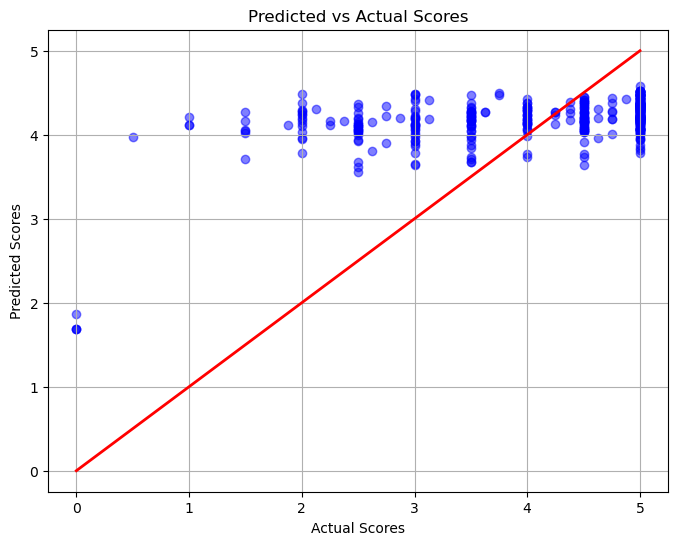

In [47]:
import matplotlib.pyplot as plt

# Plot Predicted vs Actual Scores
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.title('Predicted vs Actual Scores')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.grid(True)
plt.show()


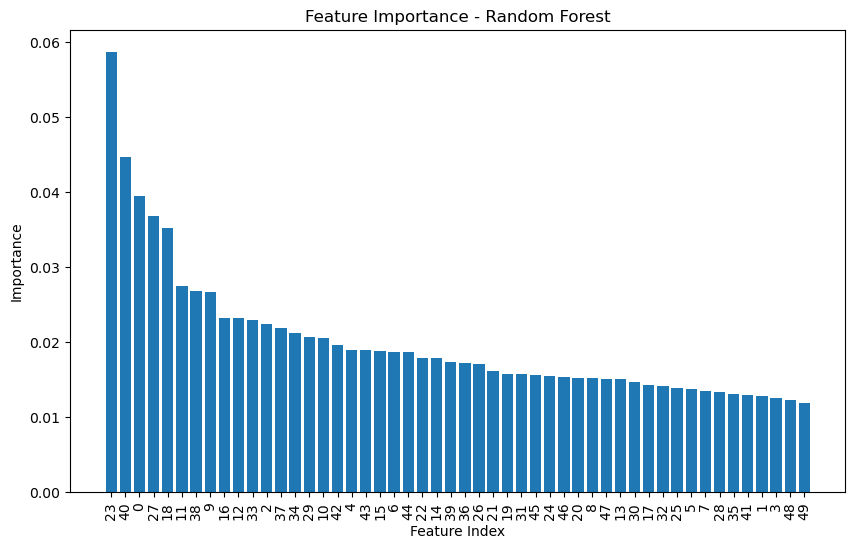

In [48]:
# Feature importance from Random Forest
importances = RF_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), indices, rotation=90)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()


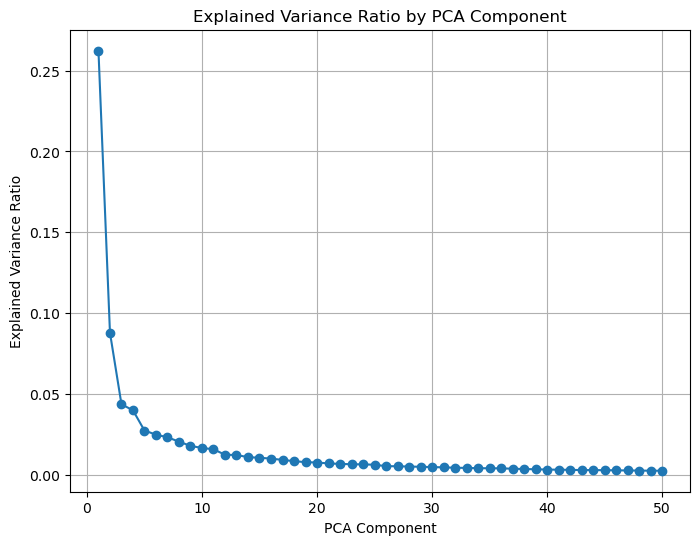

In [49]:
# Plot explained variance ratio for each PCA component
pca_explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca_explained_variance) + 1), pca_explained_variance, marker='o')
plt.title('Explained Variance Ratio by PCA Component')
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


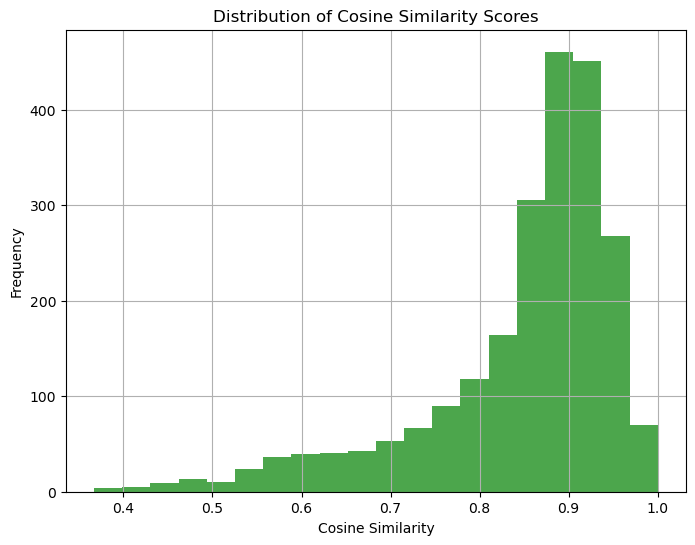

In [50]:
# Calculate similarity scores for all pairs of answers
similarity_scores = [calculate_similarity(row['student_answer'], row['desired_answer']) for _, row in data.iterrows()]

# Plot the distribution of similarity scores
plt.figure(figsize=(8, 6))
plt.hist(similarity_scores, bins=20, color='green', alpha=0.7)
plt.title('Distribution of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


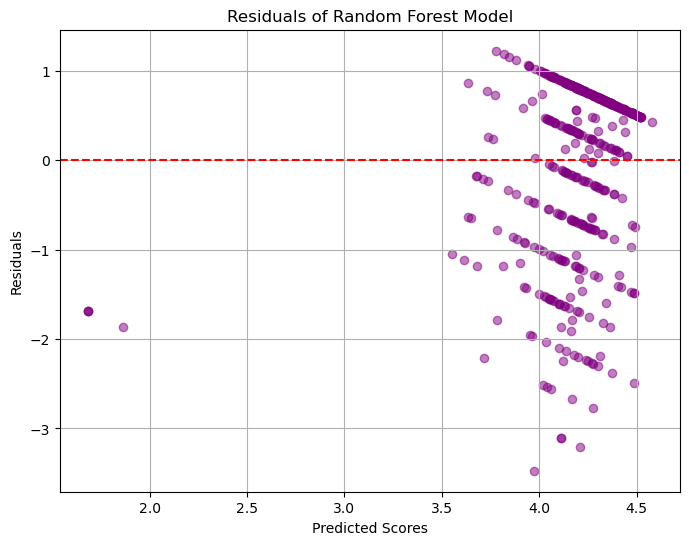

In [51]:
# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='purple', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals of Random Forest Model')
plt.xlabel('Predicted Scores')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


In [8]:
!pip install xgboost


In [44]:
from xgboost import XGBRegressor
# Define the target variable
X = reduced_features
y = data['score_avg']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBRegressor model
xgboost_model = XGBRegressor(n_estimators=100, learning_rate=0.01, max_depth=6, random_state=42)
xgboost_model.fit(X_train, y_train)

# Predictions
y_pred = xgboost_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared Score: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.023751862318529104
R-squared Score: 0.8121106546765334
Mean Absolute Error: 0.18339761220491846


In [45]:
# Prediction function for XGBoost
def predict_score_xgboost(student_answer, desired_answer):
    processed_student = preprocess_text(student_answer)
    processed_desired = preprocess_text(desired_answer)
    
    # Calculate similarity between student and desired answers
    similarity_score = calculate_similarity(processed_student, processed_desired)
    
    # Generate embeddings for the student's answer
    distilbert_embedding = get_embeddings(processed_student, distilbert_tokenizer, distilbert_model)
    roberta_embedding = get_embeddings(processed_student, roberta_tokenizer, roberta_model)
    tfidf_feature = tfidf_vectorizer.transform([processed_student]).toarray()
    
    # Combine all features
    combined_feature = np.hstack([distilbert_embedding, roberta_embedding, tfidf_feature])
    
    # Reduce dimensionality using PCA
    reduced_feature = pca.transform(combined_feature)
    
    # Predict using XGBRegressor
    xgboost_score = xgboost_model.predict(reduced_feature.reshape(1, -1))[0]
    
    # Combine semantic similarity and XGBoost model score
    final_score = (0.8 * xgboost_score) + (0.2 * similarity_score * 5)
    return final_score


In [46]:

# Example prediction
example_student_answer = "High risk problems are addressed in the prototype program to ensure feasibility. A prototype may also be used to demonstrate programmability to a company."
example_desired_answer = "To simulate the behaviour of portions of the desired software product."

predicted_score_xgboost = predict_score_xgboost(example_student_answer, example_desired_answer)
print(f'Predicted Score (XGBoost): {predicted_score_xgboost}')


Predicted Score (XGBoost): 3.6147959470748905


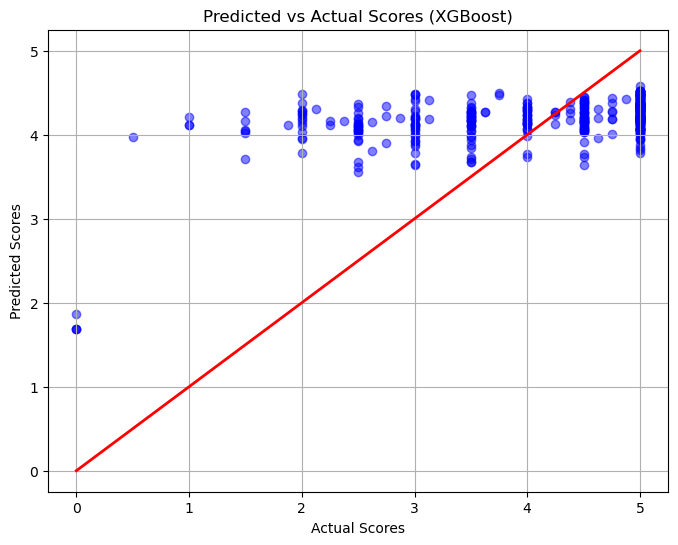

In [53]:
# Plot Predicted vs Actual Scores for XGBoost
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.title('Predicted vs Actual Scores (XGBoost)')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.grid(True)
plt.show()


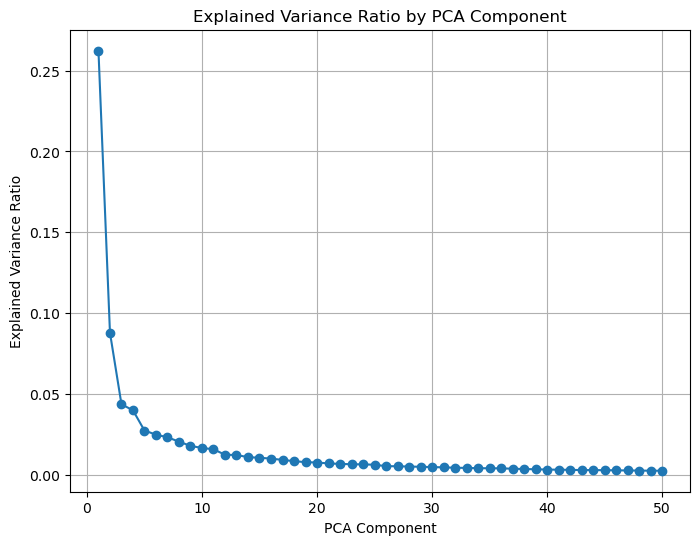

In [58]:
# Plot explained variance ratio for each PCA component
pca_explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca_explained_variance) + 1), pca_explained_variance, marker='o')
plt.title('Explained Variance Ratio by PCA Component')
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


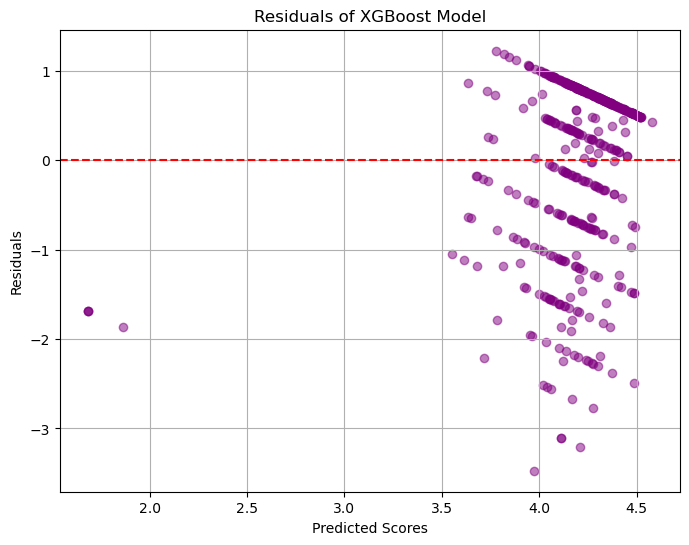

In [59]:
# Calculate residuals for XGBoost
residuals_xgboost = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals_xgboost, color='purple', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals of XGBoost Model')
plt.xlabel('Predicted Scores')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


In [63]:
from sklearn.svm import SVR

# Define the target variable
X = reduced_features
y = data['score_avg']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVR model
svm_model = SVR(kernel='rbf', C=100, gamma='auto')
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared Score: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.05973551877984118
R-squared Score: 0.7821769629453985
Mean Absolute Error: 0.3018305401227618


In [66]:
from sklearn.svm import SVR
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(student_answer, desired_answer):
    """Calculate cosine similarity between student and desired answers."""
    student_embedding = get_embeddings(student_answer, distilbert_tokenizer, distilbert_model)
    desired_embedding = get_embeddings(desired_answer, distilbert_tokenizer, distilbert_model)
    similarity = cosine_similarity(student_embedding, desired_embedding)[0][0]
    return similarity

def predict_score_svr(student_answer, desired_answer):
    """Predict the score by combining SVR and similarity-based scoring."""
    # Preprocess answers
    processed_student = preprocess_text(student_answer)
    processed_desired = preprocess_text(desired_answer)
    
    # Calculate similarity score
    similarity_score = calculate_similarity(processed_student, processed_desired)
    
    # Feature extraction for the student_answer
    distilbert_embedding = get_embeddings(processed_student, distilbert_tokenizer, distilbert_model)
    roberta_embedding = get_embeddings(processed_student, roberta_tokenizer, roberta_model)
    tfidf_feature = tfidf_vectorizer.transform([processed_student]).toarray()
    
    combined_feature = np.hstack([distilbert_embedding, roberta_embedding, tfidf_feature])
    reduced_feature = pca.transform(combined_feature)
    
    # SVR score
    svr_score = svm_model.predict(reduced_feature.reshape(1, -1))[0]
    
    # Combine similarity and SVR scores
    final_score = (0.8 * svr_score) + (0.2 * similarity_score * 5)  # Scale similarity to match score range
    return final_score

In [67]:


# Example usage
example_desired = "To simulate the behaviour of portions of the desired software product."
example_answer = "High risk problems are address in the prototype program to make sure that the program is feasible. A prototype may also be used to show a company that the software can be possibly programmed."

# Train the SVR model
svm_model = SVR(kernel='rbf', C=100, gamma='auto')
svm_model.fit(X_train, y_train)

# Predict the final score
predicted_score_svr = predict_score_svr(example_answer, example_desired)
print(f'Predicted Score (SVR + Similarity): {predicted_score_svr}')


Predicted Score (SVR + Similarity): 3.585755568485798


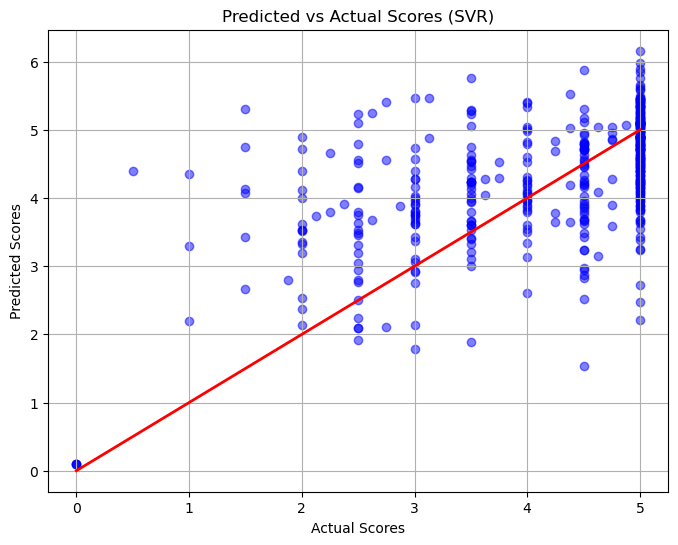

In [68]:
# Make predictions using the SVR model
y_pred_svr = svm_model.predict(X_test)

# Plot Predicted vs Actual Scores for SVR
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_svr, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.title('Predicted vs Actual Scores (SVR)')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.grid(True)
plt.show()


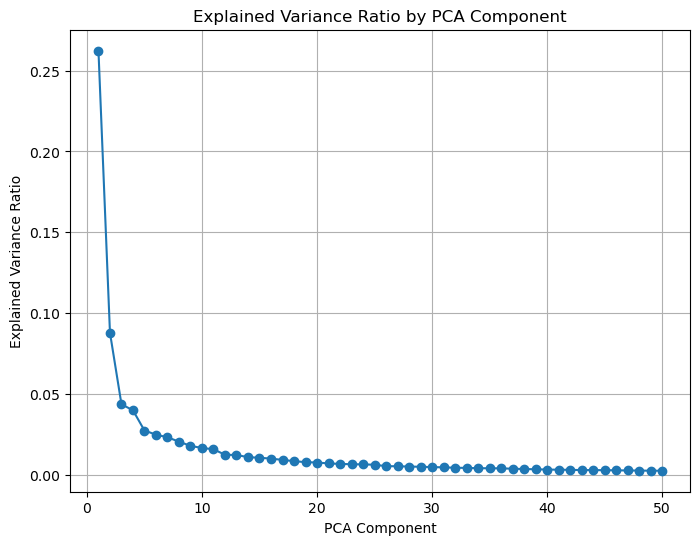

In [71]:
# Plot explained variance ratio for each PCA component
pca_explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca_explained_variance) + 1), pca_explained_variance, marker='o')
plt.title('Explained Variance Ratio by PCA Component')
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


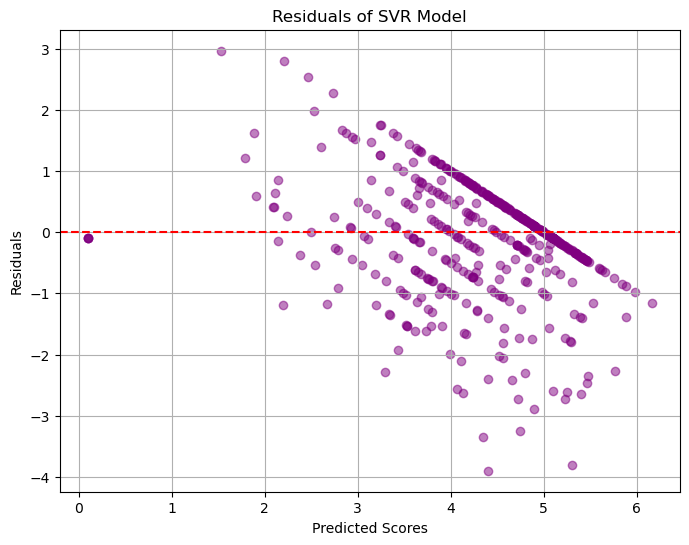

In [74]:
# Calculate residuals for SVR
residuals_svr = y_test - y_pred_svr

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_svr, residuals_svr, color='purple', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals of SVR Model')
plt.xlabel('Predicted Scores')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


In [73]:
!pip install matplotlib seaborn scipy statsmodels


In [84]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

In [93]:
# Define the target variable
X = reduced_features
y = data['score_avg']

# Reshape X for LSTM input (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=32, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')



# Train the model
history = lstm_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_pred = lstm_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared Score: {r2}')
print(f'Mean Absolute Error: {mae}')

Epoch 1/30
18/18 [==============================] - 4s 50ms/step - loss: 18.1545 - val_loss: 18.0058
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 17.3441 - val_loss: 16.9430
Epoch 3/30
18/18 [==============================] - 0s 7ms/step - loss: 15.9071 - val_loss: 14.9423
Epoch 4/30
18/18 [==============================] - 0s 7ms/step - loss: 13.2042 - val_loss: 11.3594
Epoch 5/30
18/18 [==============================] - 0s 7ms/step - loss: 8.9631 - val_loss: 6.4743
Epoch 6/30
18/18 [==============================] - 0s 7ms/step - loss: 4.3298 - val_loss: 2.5879
Epoch 7/30
18/18 [==============================] - 0s 7ms/step - loss: 1.9569 - val_loss: 1.3794
Epoch 8/30
18/18 [==============================] - 0s 7ms/step - loss: 1.4905 - val_loss: 1.1629
Epoch 9/30
18/18 [==============================] - 0s 7ms/step - loss: 1.3225 - val_loss: 1.0695
Epoch 10/30
18/18 [==============================] - 0s 7ms/step - loss: 1.2390 - val_loss: 1.0278
Epoch 11/3

In [97]:
print(history.history.keys())


dict_keys(['loss', 'val_loss'])


In [101]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(student_answer, desired_answer):
    """Calculate cosine similarity between student and desired answers."""
    student_embedding = get_embeddings(student_answer, distilbert_tokenizer, distilbert_model)
    desired_embedding = get_embeddings(desired_answer, distilbert_tokenizer, distilbert_model)
    similarity = cosine_similarity(student_embedding, desired_embedding)[0][0]
    return similarity

def predict_score_lstm(student_answer, desired_answer):
    """Predict the score by combining LSTM and similarity-based scoring."""
    # Preprocess answers
    processed_student = preprocess_text(student_answer)
    processed_desired = preprocess_text(desired_answer)
    
    # Calculate similarity score
    similarity_score = calculate_similarity(processed_student, processed_desired)
    
    # Feature extraction for the student_answer
    distilbert_embedding = get_embeddings(processed_student, distilbert_tokenizer, distilbert_model)
    roberta_embedding = get_embeddings(processed_student, roberta_tokenizer, roberta_model)
    tfidf_feature = tfidf_vectorizer.transform([processed_student]).toarray()
    
    combined_feature = np.hstack([distilbert_embedding, roberta_embedding, tfidf_feature])
    reduced_feature = pca.transform(combined_feature)
    
    # Reshape for LSTM input
    lstm_feature = reduced_feature.reshape((1, 1, reduced_feature.shape[1]))
    
    # LSTM score
    lstm_score = lstm_model.predict(lstm_feature)[0][0]
    
    # Combine similarity and LSTM scores
    final_score = (0.8 * lstm_score) + (0.2 * similarity_score * 5)  # Scale similarity to match score range
    return final_score



In [102]:
# Example usage
example_desired = "To simulate the behaviour of portions of the desired software product."
example_answer = "High risk problems are address in the prototype program to make sure that the program is feasible. A prototype may also be used to show a company that the software can be possibly programmed."

predicted_score_lstm = predict_score_lstm(example_answer, example_desired)
print(f'Predicted Score (LSTM + Similarity): {predicted_score_lstm}')


1/1 [==============================] - 0s 26ms/step
Predicted Score (LSTM + Similarity): 3.567262876033783


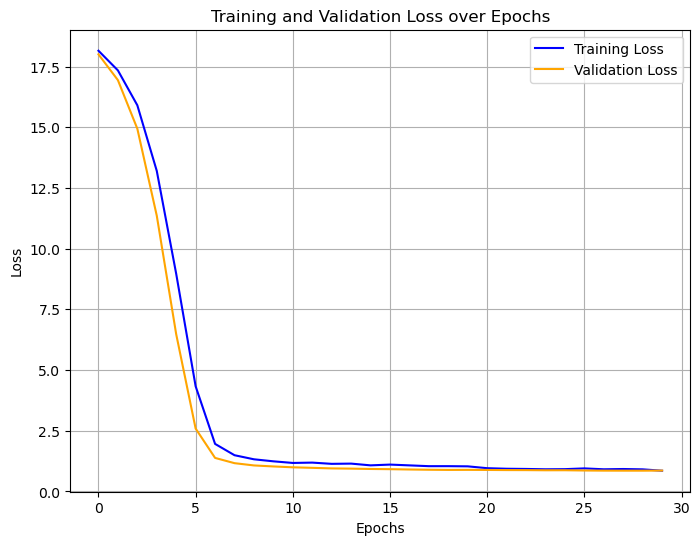

In [98]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


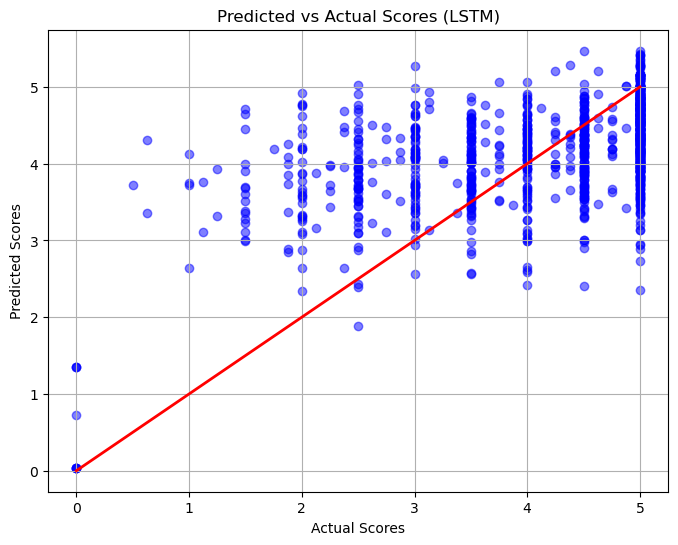

In [103]:
# Convert predictions to 1D array for plotting
y_pred_flat = y_pred.flatten()

# Predicted vs Actual Scores
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_flat, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.title('Predicted vs Actual Scores (LSTM)')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.grid(True)
plt.show()


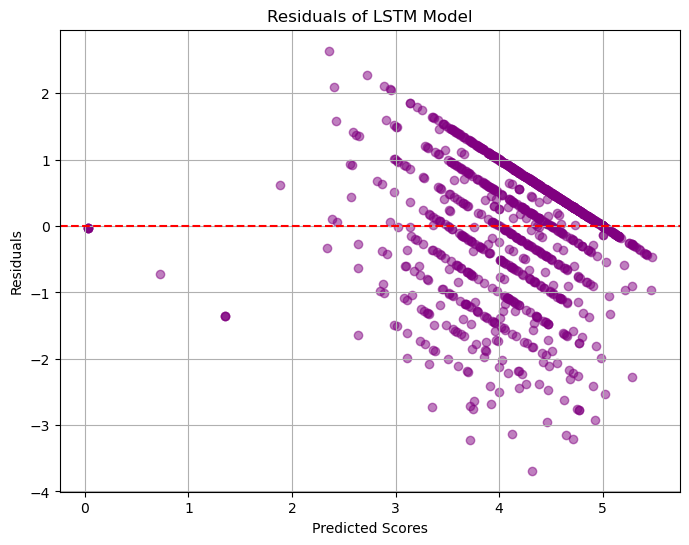

In [104]:
# Calculate residuals
residuals = y_test - y_pred_flat

# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_flat, residuals, color='purple', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals of LSTM Model')
plt.xlabel('Predicted Scores')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


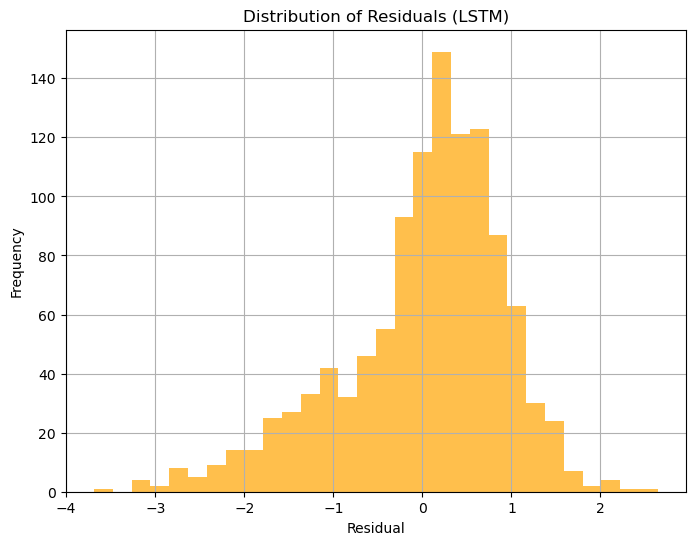

In [105]:
# Plot histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='orange', alpha=0.7)
plt.title('Distribution of Residuals (LSTM)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


2. GRU

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
# Define the target variable
X = reduced_features
y = data['score_avg']

# Reshape X for GRU input (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=32, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=1))

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = gru_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_pred = gru_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared Score: {r2}')
print(f'Mean Absolute Error: {mae}')

Epoch 1/30
9/9 [==============================] - 4s 82ms/step - loss: 18.1466 - val_loss: 17.8331
Epoch 2/30
9/9 [==============================] - 0s 8ms/step - loss: 17.0984 - val_loss: 16.7349
Epoch 3/30
9/9 [==============================] - 0s 10ms/step - loss: 15.9363 - val_loss: 15.3611
Epoch 4/30
9/9 [==============================] - 0s 9ms/step - loss: 14.3605 - val_loss: 13.5601
Epoch 5/30
9/9 [==============================] - 0s 9ms/step - loss: 12.3560 - val_loss: 11.2620
Epoch 6/30
9/9 [==============================] - 0s 8ms/step - loss: 9.9291 - val_loss: 8.5611
Epoch 7/30
9/9 [==============================] - 0s 9ms/step - loss: 7.2158 - val_loss: 5.7456
Epoch 8/30
9/9 [==============================] - 0s 9ms/step - loss: 4.5797 - val_loss: 3.3508
Epoch 9/30
9/9 [==============================] - 0s 9ms/step - loss: 2.6904 - val_loss: 1.8398
Epoch 10/30
9/9 [==============================] - 0s 9ms/step - loss: 1.7504 - val_loss: 1.2328
Epoch 11/30
9/9 [==========

In [137]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(student_answer, desired_answer):
    """Calculate cosine similarity between student and desired answers."""
    student_embedding = get_embeddings(student_answer, distilbert_tokenizer, distilbert_model)
    desired_embedding = get_embeddings(desired_answer, distilbert_tokenizer, distilbert_model)
    similarity = cosine_similarity(student_embedding, desired_embedding)[0][0]
    return similarity

def predict_score_gru(student_answer, desired_answer):
    """Predict the score by combining GRU and similarity-based scoring."""
    # Preprocess answers
    processed_student = preprocess_text(student_answer)
    processed_desired = preprocess_text(desired_answer)
    
    # Calculate similarity score
    similarity_score = calculate_similarity(processed_student, processed_desired)
    
    # Feature extraction for the student_answer
    distilbert_embedding = get_embeddings(processed_student, distilbert_tokenizer, distilbert_model)
    roberta_embedding = get_embeddings(processed_student, roberta_tokenizer, roberta_model)
    tfidf_feature = tfidf_vectorizer.transform([processed_student]).toarray()
    
    combined_feature = np.hstack([distilbert_embedding, roberta_embedding, tfidf_feature])
    reduced_feature = pca.transform(combined_feature)
    
    # Reshape for GRU input
    gru_feature = reduced_feature.reshape((1, 1, reduced_feature.shape[1]))
    
    # GRU score
    gru_score = gru_model.predict(gru_feature)[0][0]
    
    # Combine similarity and GRU scores
    final_score = (0.8 * gru_score) + (0.2 * similarity_score * 5)  # Scale similarity to match score range
    return final_score




In [138]:



# Example usage
example_desired = "To simulate the behaviour of portions of the desired software product."
example_answer = "High risk problems are address in the prototype program to make sure that the program is feasible. A prototype may also be used to show a company that the software can be possibly programmed."

predicted_score_gru = predict_score_gru(example_answer, example_desired)
print(f'Predicted Score (GRU + Similarity): {predicted_score_gru}')


1/1 [==============================] - 0s 16ms/step
Predicted Score (GRU + Similarity): 3.5770362973213192


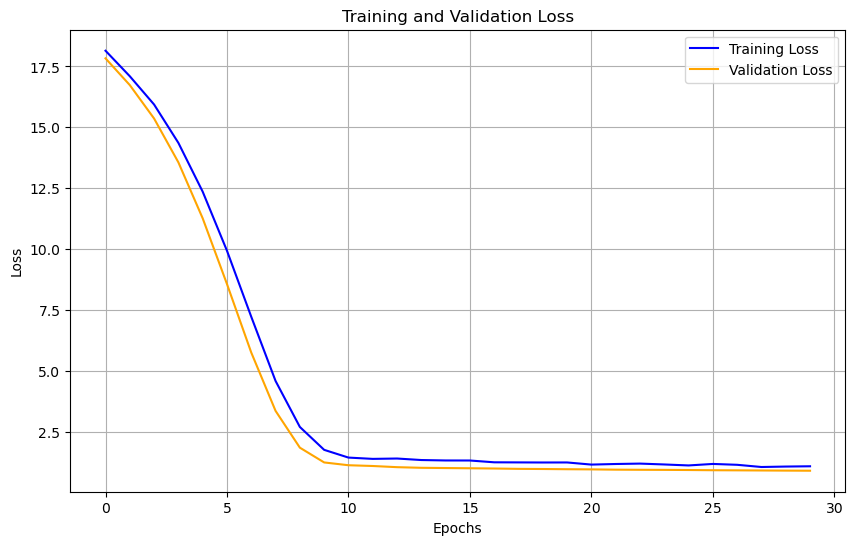

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



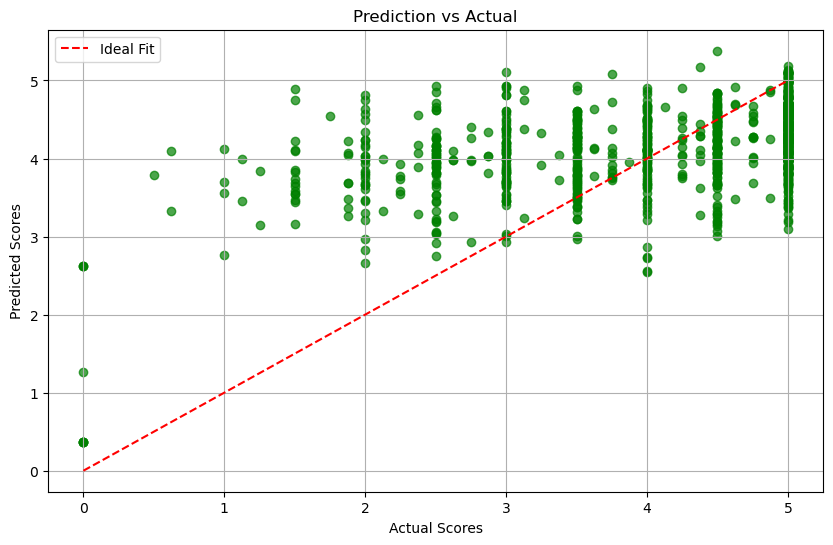

In [140]:
# 2. Prediction vs. Actual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.title('Prediction vs Actual')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.legend()
plt.grid(True)
plt.show()



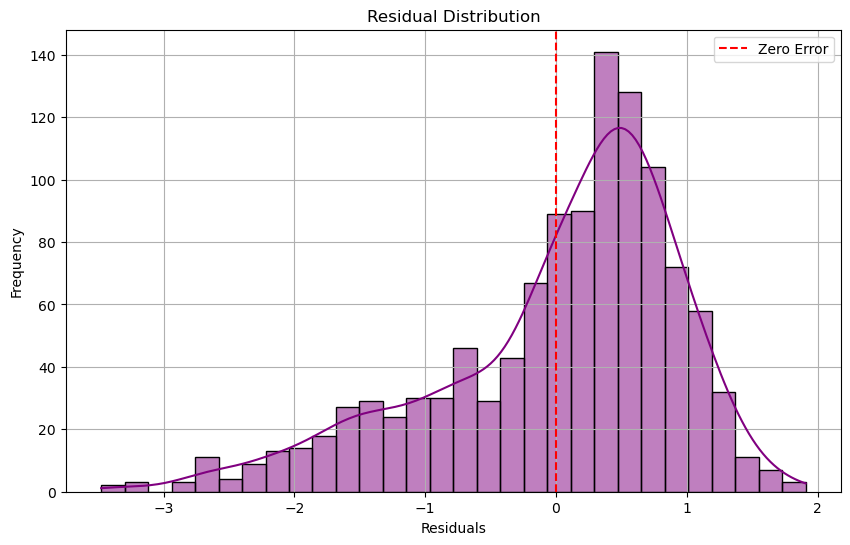

In [141]:
# 3. Residual Plot
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.legend()
plt.grid(True)
plt.show()



In [177]:
from keras.models import Sequential
from keras.layers import Bidirectional, SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the target variable
X = reduced_features  # Features (make sure reduced_features are preprocessed)
y = data['score_avg']  # Target variable (grades)

# Reshape X for RNN input (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))  # If your data is not sequential, 1 timestep can be used

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the BiRNN model
bi_rnn_model = Sequential()
bi_rnn_model.add(Bidirectional(SimpleRNN(units=64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
bi_rnn_model.add(Dropout(0.2))
bi_rnn_model.add(Bidirectional(SimpleRNN(units=32, return_sequences=False)))
bi_rnn_model.add(Dropout(0.2))
bi_rnn_model.add(Dense(units=1))  # Output layer for regression (predicting score)

# Compile the model
bi_rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = bi_rnn_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_pred = bi_rnn_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output evaluation results
print(f'Mean Squared Error: {1-mse}')
print(f'R-squared Score: {1-r2}')
print(f'Mean Absolute Error: {mae}')


Epoch 1/30
9/9 [==============================] - 3s 55ms/step - loss: 17.8764 - val_loss: 15.6707
Epoch 2/30
9/9 [==============================] - 0s 9ms/step - loss: 14.8396 - val_loss: 13.0750
Epoch 3/30
9/9 [==============================] - 0s 8ms/step - loss: 11.8271 - val_loss: 10.2718
Epoch 4/30
9/9 [==============================] - 0s 9ms/step - loss: 8.9618 - val_loss: 7.4452
Epoch 5/30
9/9 [==============================] - 0s 9ms/step - loss: 6.4606 - val_loss: 4.8472
Epoch 6/30
9/9 [==============================] - 0s 12ms/step - loss: 4.1381 - val_loss: 2.8452
Epoch 7/30
9/9 [==============================] - 0s 9ms/step - loss: 2.6944 - val_loss: 1.8172
Epoch 8/30
9/9 [==============================] - 0s 9ms/step - loss: 2.1293 - val_loss: 1.5514
Epoch 9/30
9/9 [==============================] - 0s 9ms/step - loss: 2.0538 - val_loss: 1.4090
Epoch 10/30
9/9 [==============================] - 0s 9ms/step - loss: 1.9492 - val_loss: 1.3174
Epoch 11/30
9/9 [==============

In [178]:


def calculate_similarity(student_answer, desired_answer):
    """Calculate cosine similarity between student and desired answers."""
    student_embedding = get_embeddings(student_answer, distilbert_tokenizer, distilbert_model)
    desired_embedding = get_embeddings(desired_answer, distilbert_tokenizer, distilbert_model)
    similarity = cosine_similarity(student_embedding, desired_embedding)[0][0]
    return similarity

def predict_score_birnn(student_answer, desired_answer, bi_rnn_model):
    """Predict the score by combining BiRNN and similarity-based scoring."""
    # Preprocess answers
    processed_student = preprocess_text(student_answer)
    processed_desired = preprocess_text(desired_answer)
    
    # Calculate similarity score
    similarity_score = calculate_similarity(processed_student, processed_desired)
    
    # Feature extraction for the student_answer
    distilbert_embedding = get_embeddings(processed_student, distilbert_tokenizer, distilbert_model)
    roberta_embedding = get_embeddings(processed_student, roberta_tokenizer, roberta_model)
    tfidf_feature = tfidf_vectorizer.transform([processed_student]).toarray()
    
    combined_feature = np.hstack([distilbert_embedding, roberta_embedding, tfidf_feature])
    reduced_feature = pca.transform(combined_feature)
    
    # Reshape for BiRNN input
    birnn_feature = reduced_feature.reshape((1, 1, reduced_feature.shape[1]))
    
    # BiRNN score
    birnn_score = bi_rnn_model.predict(birnn_feature)[0][0]
    
    # Combine similarity and BiRNN scores
    final_score = (0.7 * birnn_score) + (0.3 * similarity_score * 5)  # Scale similarity to match score range
    return final_score


# Example usage
example_desired = "To simulate the behaviour of portions of the desired software product."
example_answer = "High risk problems are addressed in the prototype program to make sure that the program is feasible. A prototype may also be used to show a company that the software can be possibly programmed."

# Ensure bi_rnn_model is passed into the function
predicted_score_birnn = predict_score_birnn(example_answer, example_desired, bi_rnn_model)
print(f'Predicted Score (BiRNN + Similarity): {predicted_score_birnn}')

1/1 [==============================] - 0s 25ms/step
Predicted Score (BiRNN + Similarity): 3.632998788356781


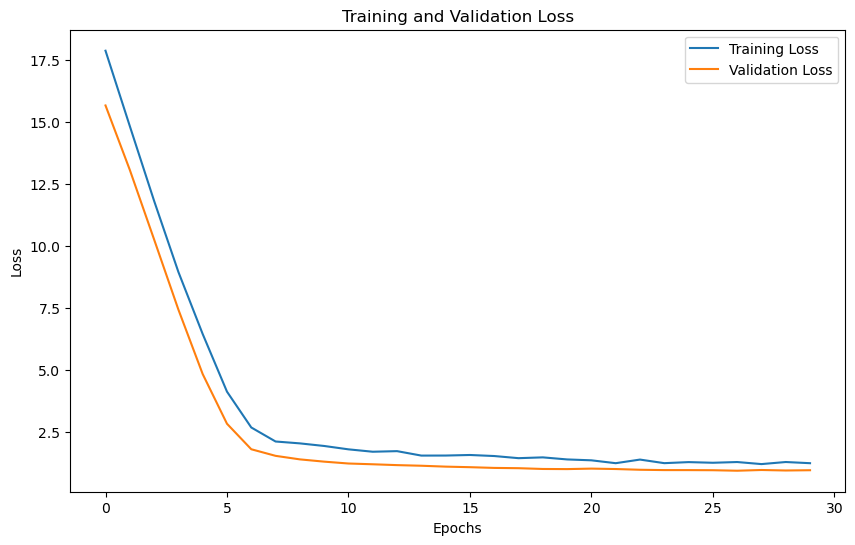

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# 1. Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



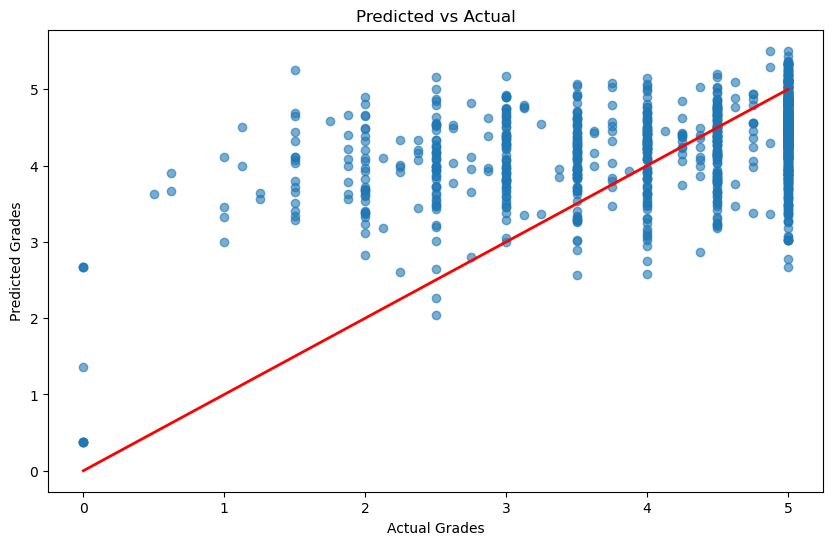

In [182]:
# Predicted vs Actual (Scatter Plot)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Ideal line
plt.title('Predicted vs Actual')
plt.xlabel('Actual Grades')
plt.ylabel('Predicted Grades')
plt.show()



C:\Users\User\AppData\Local\Temp\ipykernel_1280\1053729329.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label='Actual Grades', shade=True)
C:\Users\User\AppData\Local\Temp\ipykernel_1280\1053729329.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred, label='Predicted Grades', shade=False)


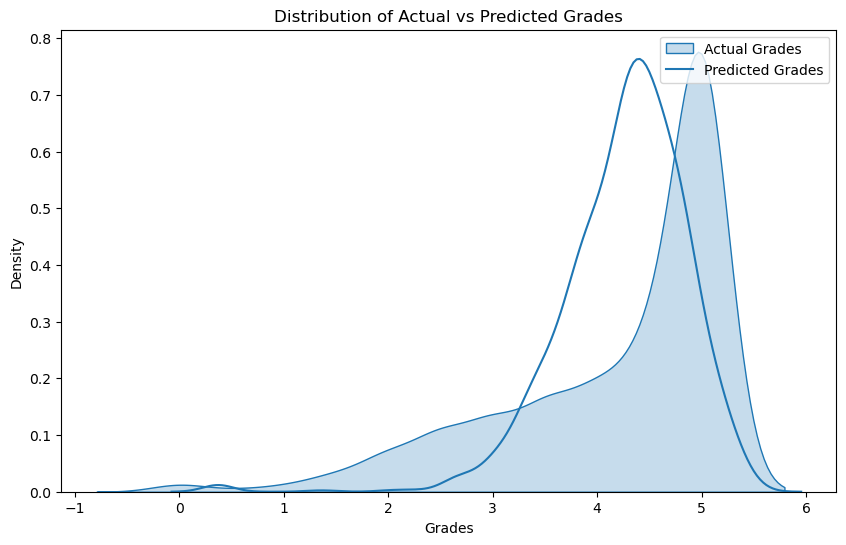

In [185]:
# Distribution of Actual and Predicted Values
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual Grades', shade=True)
sns.kdeplot(y_pred, label='Predicted Grades', shade=False)
plt.title('Distribution of Actual vs Predicted Grades')
plt.xlabel('Grades')
plt.ylabel('Density')
plt.legend()
plt.show()



In [189]:
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")


Shape of y_test: (1137,)
Shape of y_pred: (1137, 1)


In [190]:
y_pred = y_pred.ravel()  # Convert to 1D array


In [191]:
y_test = y_test.ravel()  # Convert to 1D array


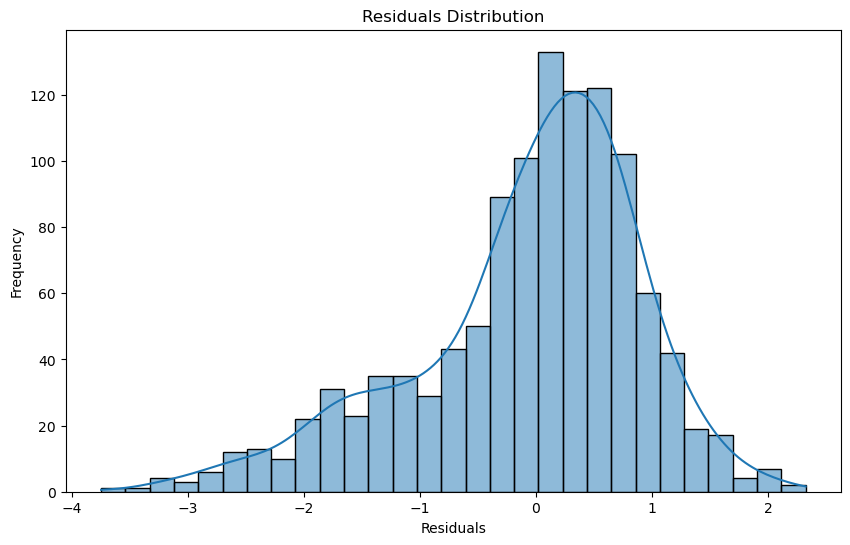

In [192]:
# Calculate residuals (difference between actual and predicted)
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
